In [1]:
using DifferentialEquations, Plots, LinearAlgebra

# Premilinaries

In [2]:
# Number of dimesions (2 or 3)
const dim = 2;

# Gravitational constant in SI
const G₀ = 6.674 * 1e-11 # in m^3 / kg / s^2

# Natural units for Solar Celestical Mechanics
const Mₑ = 5.97 * 1e24 # mass of the Earth in kg
const Mₛ = 1.99 * 1e30 # mass of the Sun in kg
const AU = 1.49 * 1e11 # astronomical unit in m
const yr = 3.15 * 1e7  # year in seconds

const G = G₀ * Mₛ * yr^2 / AU^3

39.838371858211836

$\ddot{\vec{r}}_i = -G\sum_{j\neq i} \frac{m_j}{|\vec{r}_i-\vec{r}_j|^2}\frac{\vec{r}_i-\vec{r}_j}{|\vec{r}_i-\vec{r}_j|}$

In [3]:
# Acceleration as a function of position and mass
function acceleration(rᵢ,rⱼ,mⱼ)
    Δr = rᵢ-rⱼ
    return -G * mⱼ * Δr / norm(Δr)^3
end

acceleration (generic function with 1 method)

In [4]:
# A quick test
r₁ = [1, 0]
r₂ = [0, 1]

a₁ = acceleration(r₁,r₂,1)

2-element Vector{Float64}:
 -14.084991446186452
  14.084991446186452

# Software for solving the dynamics

We will use Julia's DifferentialEquations.jl.

- First-order ordinary differential equations (ODE) can be solved with the `ODEProblem` object;
- Second-order ODEs can be solved by converting them to larger first-order ODEs or with `SecondOrderODEProblem`.

See [documentation](https://diffeq.sciml.ai/stable/types/dynamical_types/) or [tutorials](https://tutorials.sciml.ai/html/models/01-classical_physics.html).

# Motion of a Planet around a Sun

In [5]:
const r☼ = [0.0,0.0]

function a(v,r,p,t)
    return acceleration(r, r☼, 1.0)
end

a (generic function with 1 method)

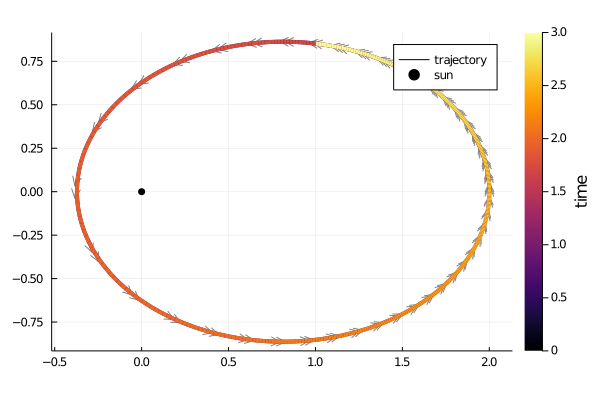

In [6]:
r₀ = [2.0, 0.0]
v₀ = [0.0, 2.5] # try [0.0, 4.5] for mostly circular motion
tspan = (0.0, 3.0)

planetsun_problem = SecondOrderODEProblem(a, v₀, r₀, tspan)
planetsun_solution = solve(planetsun_problem);

ts = range(tspan[1], tspan[end], length=1000)
x = [planetsun_solution(t)[3] for t in ts]
y = [planetsun_solution(t)[4] for t in ts]
vx = [planetsun_solution(t)[1] for t in ts]
vy = [planetsun_solution(t)[2] for t in ts];

plot()

quiver!(x[1:10:end],y[1:10:end],quiver=(vx[1:10:end]/100,vy[1:10:end]/100),
    color=:grey, label="velocity")

plot!(x,y,line_z=ts,
    linewidth=4, label="trajectory")
plot!(colorbar_title="time")

plot!([r☼[1]],[r☼[2]],
    line=nothing, marker=:circle, color=:black, label="sun")

plot!(aspectratio=:equal)

┌ Info: Saved animation to 
│   fn = /home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif
└ @ Plots /home/stefan/.julia/packages/Plots/z5Msu/src/animation.jl:104


Plots.AnimatedGif("/home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif")
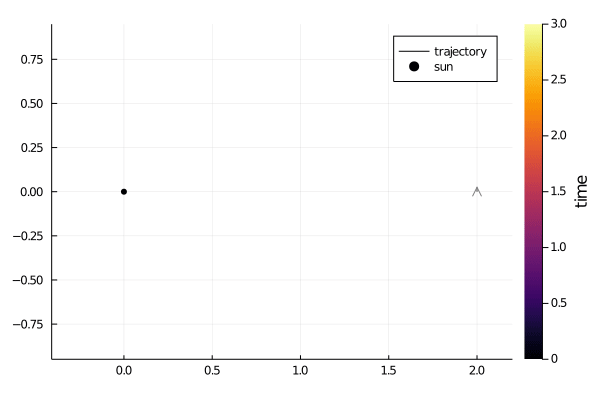

In [7]:
@gif for i in 1:10:length(ts)
    plot()

    quiver!([x[i]],[y[i]],quiver=([vx[i]]/100,[vy[i]]/100),
        color=:grey, label="velocity")

    plot!(x[1:i],y[1:i],line_z=ts[1:i],clim=extrema(ts),
        linewidth=4, label="trajectory")
    plot!(colorbar_title="time")

    plot!([r☼[1]],[r☼[2]],
        line=nothing, marker=:circle, color=:black, label="sun")

    plot!(aspectratio=:equal,xlim=extrema(x).*1.1,ylim=extrema(y).*1.1)
end

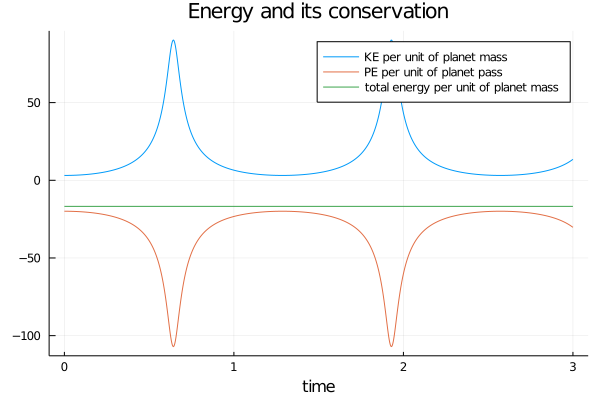

In [8]:
KE = (vx.^2 .+ vy.^2)./2
PE = -G*1.0 ./ sqrt.(x.^2 .+ y.^2)
plot(ts, KE, label="KE per unit of planet mass")
plot!(ts, PE, label="PE per unit of planet pass")
plot!(ts, PE.+KE, label="total energy per unit of planet mass")
plot!(xlabel="time",title="Energy and its conservation")

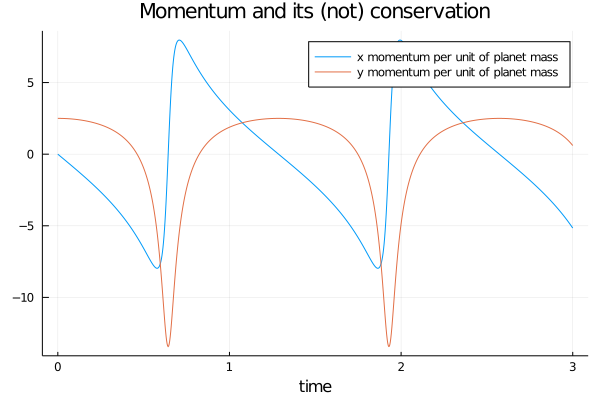

In [9]:
px = vx # momentum per unit of planet mass (duh, it is just velocity)
py = vy

plot(ts, px, label="x momentum per unit of planet mass")
plot!(ts, py, label="y momentum per unit of planet mass")
plot!(xlabel="time",title="Momentum and its (not) conservation")

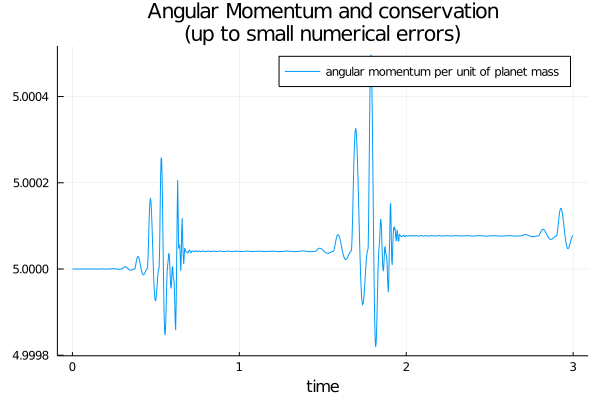

In [10]:
L = x .* vy - y .* vx

plot(ts, L, label="angular momentum per unit of planet mass")
plot!(xlabel="time",title="Angular Momentum and conservation\n(up to small numerical errors)")

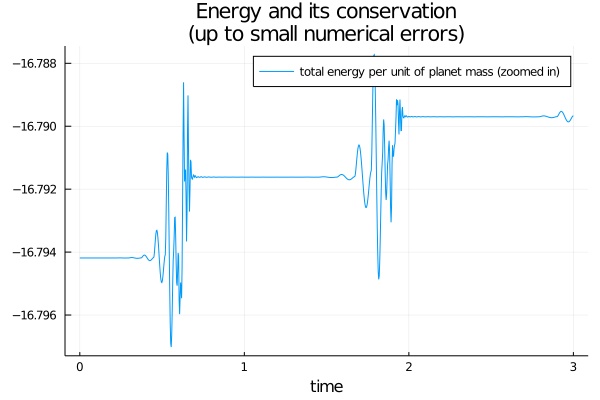

In [11]:
KE = (vx.^2 .+ vy.^2)./2
PE = -G*1.0 ./ sqrt.(x.^2 .+ y.^2)
plot(ts, PE.+KE, label="total energy per unit of planet mass (zoomed in)")
plot!(xlabel="time",title="Energy and its conservation\n(up to small numerical errors)")

# Many Body Systems

## Central Sun + Multiple Planets

In [12]:
r₀ = [ # Each row is the initial position of a different body
    1.0 0.0;
    4.0 0.0;
    8.0 0.0
]

v₀ = [
    0.0  6.0;
    0.0  3.0;
    0.0  2.0;
]

function a(v,r,p,t) # Only interaction between sun and planets. No planet-planet interaction.
    acc = zero(r)    
    N, d = size(acc) # N is the number of planets
    for i in 1:N
        acc[i,:] = acceleration(r[i,:], r☼, 1.0)
    end
    return acc
end

a (generic function with 1 method)

In [13]:
tspan = (0.0, 5.0)
mplanetsun_problem = SecondOrderODEProblem(a, v₀, r₀, tspan)
mplanetsun_solution = solve(mplanetsun_problem);

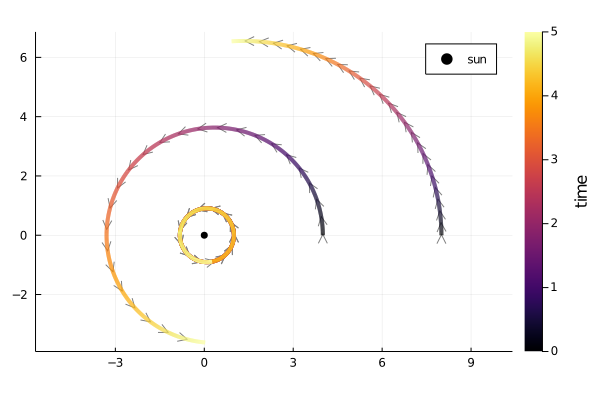

In [14]:
ts = range(tspan[1], tspan[end], length=1000)

plot()

N, d = size(r₀)
for i in 1:N
    x = [mplanetsun_solution(t)[2,i,1] for t in ts]
    y = [mplanetsun_solution(t)[2,i,2] for t in ts]
    vx = [mplanetsun_solution(t)[1,i,1] for t in ts]
    vy = [mplanetsun_solution(t)[1,i,2] for t in ts];

    quiver!(x[1:40:end],y[1:40:end],quiver=(vx[1:40:end]/100,vy[1:40:end]/100),
        color=:grey, label=nothing)

    plot!(x,y,line_z=ts,
        linewidth=4, label=nothing)
end
    
plot!(colorbar_title="time")

plot!([r☼[1]],[r☼[2]],
    line=nothing, marker=:circle, color=:black, label="sun")

plot!(aspectratio=:equal)

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

┌ Info: Saved animation to 
│   fn = /home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif
└ @ Plots /home/stefan/.julia/packages/Plots/z5Msu/src/animation.jl:104


Plots.AnimatedGif("/home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif")
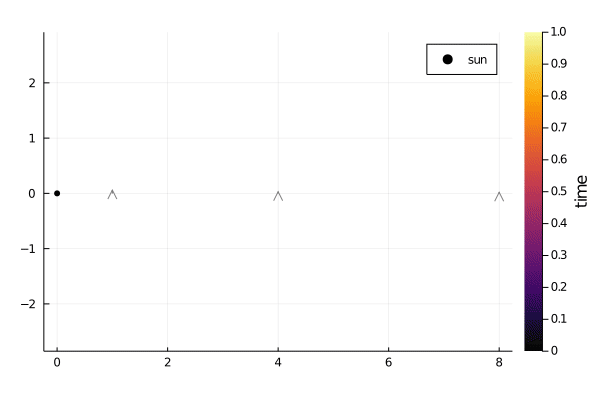

In [15]:
x = [[mplanetsun_solution(t)[2,i,1] for t in ts] for i in 1:N]
y = [[mplanetsun_solution(t)[2,i,2] for t in ts] for i in 1:N]
vx = [[mplanetsun_solution(t)[1,i,1] for t in ts] for i in 1:N]
vy = [[mplanetsun_solution(t)[1,i,2] for t in ts] for i in 1:N]

@gif for ti in 1:10:length(ts)
    print(ti, " ")
    plot()

    for i in 1:N
        quiver!(x[i][1:40:ti],y[i][1:40:ti],quiver=(vx[i][1:40:ti]/100,vy[i][1:40:ti]/100),
            color=:grey, label=nothing)

        plot!(x[i][1:ti],y[i][1:ti],line_z=ts[1:ti],
            linewidth=4, label=nothing)
    end

    plot!(colorbar_title="time")

    plot!([r☼[1]],[r☼[2]],
        line=nothing, marker=:circle, color=:black, label="sun")

    plot!(aspectratio=:equal)
end

## Include planet-planet interaction

In [16]:
function a(v,r,p,t) # p will be the mass of each planet
    acc = zero(r)    
    N, d = size(acc) # N is the number of planets
    for i in 1:N # You can comment out this section if you want to include the sun explicitly as one of the bodies
        acc[i,:] = acceleration(r[i,:], r☼, 1.0)
    end
    for i in 1:N # planet on which the force is applied
        for j in 1:N # planet causing the force
            if i==j
                continue
            end
            acc[i,:] += acceleration(r[i,:], r[j,:], p[j])
        end
    end
    return acc
end

a (generic function with 1 method)

In [17]:
r₀ = [
    1.0 0.0;
    4.0 0.0;
    8.0 0.0
]

v₀ = [
    0.0  6.0;
    0.0  3.0;
    0.0  2.0;
]

masses = [0.01, 0.01, 0.2]

tspan = (0.0, 50.0)
pps_problem = SecondOrderODEProblem(a, v₀, r₀, tspan, masses)
pps_solution = solve(pps_problem);

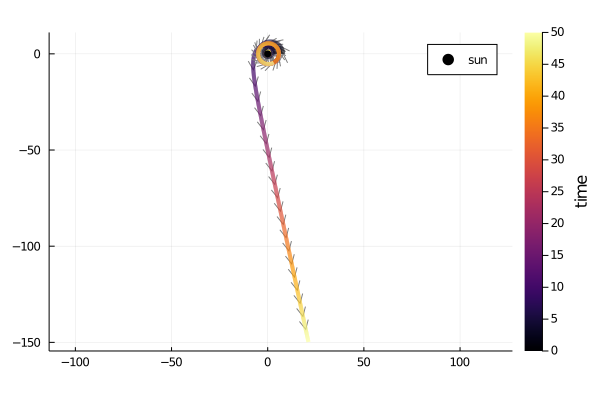

In [18]:
ts = range(tspan[1], tspan[end], length=1000)

plot()

N, d = size(r₀)
for i in 1:N
    x = [pps_solution(t)[2,i,1] for t in ts]
    y = [pps_solution(t)[2,i,2] for t in ts]
    vx = [pps_solution(t)[1,i,1] for t in ts]
    vy = [pps_solution(t)[1,i,2] for t in ts];

    quiver!(x[1:40:end],y[1:40:end],quiver=(vx[1:40:end]/100,vy[1:40:end]/100),
        color=:grey, label=nothing)

    plot!(x,y,line_z=ts,
        linewidth=4, label=nothing)
end
    
plot!(colorbar_title="time")

plot!([r☼[1]],[r☼[2]],
    line=nothing, marker=:circle, color=:black, label="sun")

plot!(aspectratio=:equal)

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

┌ Info: Saved animation to 
│   fn = /home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif
└ @ Plots /home/stefan/.julia/packages/Plots/z5Msu/src/animation.jl:104


Plots.AnimatedGif("/home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif")
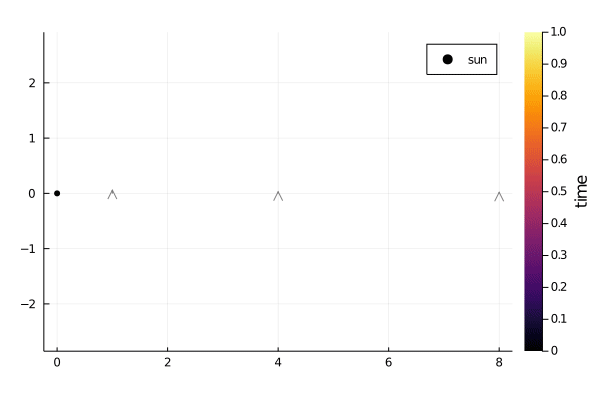

In [19]:
x = [[pps_solution(t)[2,i,1] for t in ts] for i in 1:N]
y = [[pps_solution(t)[2,i,2] for t in ts] for i in 1:N]
vx = [[pps_solution(t)[1,i,1] for t in ts] for i in 1:N]
vy = [[pps_solution(t)[1,i,2] for t in ts] for i in 1:N]

@gif for ti in 1:10:length(ts)
    print(ti, " ")
    plot()

    for i in 1:N
        quiver!(x[i][1:40:ti],y[i][1:40:ti],quiver=(vx[i][1:40:ti]/100,vy[i][1:40:ti]/100),
            color=:grey, label=nothing)

        plot!(x[i][1:ti],y[i][1:ti],line_z=ts[1:ti],
            linewidth=4, label=nothing)
    end

    plot!(colorbar_title="time")

    plot!([r☼[1]],[r☼[2]],
        line=nothing, marker=:circle, color=:black, label="sun")

    plot!(aspectratio=:equal)
end

# All body-body interactions, without hardcoded fixed star in the center

We will explicitly simulate the motion of the star

In [20]:
function a(v,r,p,t) # p will be the mass of each planet
    acc = zero(r)    
    N, d = size(acc) # N is the number of planets
    for i in 1:N # planet on which the force is applied
        for j in 1:N # planet causing the force
            if i==j
                continue
            end
            acc[i,:] += acceleration(r[i,:], r[j,:], p[j])
        end
    end
    return acc
end

a (generic function with 1 method)

In [21]:
r₀ = [
    0.0 0.0; # The sun, explicitly put in the center
    1.0 0.0;
    4.0 0.0;
    8.0 0.0
]

v₀ = [
    0.0  0.0; # The sun, with zero initial velocity
    0.0  6.0;
    0.0  3.0;
    0.0  3.0;
]

masses = [10, 0.01, 0.01, 0.2] # The first mass is of the sun, which is much heavier

tspan = (0.0, 5.0)
pps_problem = SecondOrderODEProblem(a, v₀, r₀, tspan, masses)
pps_solution = solve(pps_problem);

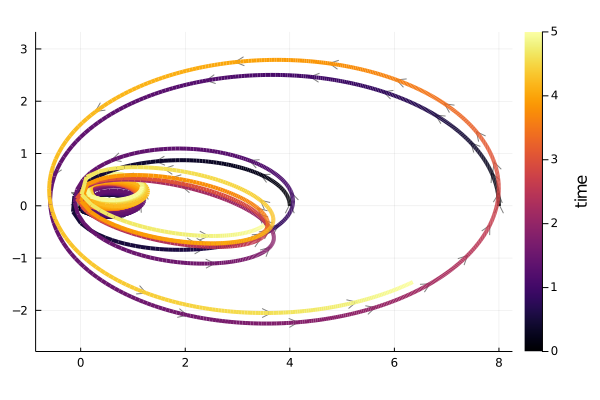

In [22]:
ts = range(tspan[1], tspan[end], length=1000)

plot()

N, d = size(r₀)
for i in 1:N
    x = [pps_solution(t)[2,i,1] for t in ts]
    y = [pps_solution(t)[2,i,2] for t in ts]
    vx = [pps_solution(t)[1,i,1] for t in ts]
    vy = [pps_solution(t)[1,i,2] for t in ts];

    quiver!(x[1:40:end],y[1:40:end],quiver=(vx[1:40:end]/100,vy[1:40:end]/100),
        color=:grey, label=nothing)

    plot!(x,y,line_z=ts,
        linewidth=4, label=nothing)
end
    
plot!(colorbar_title="time")

plot!(aspectratio=:equal)

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

┌ Info: Saved animation to 
│   fn = /home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif
└ @ Plots /home/stefan/.julia/packages/Plots/z5Msu/src/animation.jl:104


Plots.AnimatedGif("/home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif")
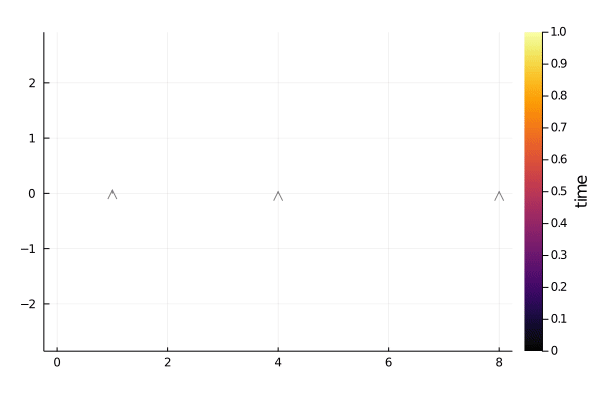

In [23]:
x = [[pps_solution(t)[2,i,1] for t in ts] for i in 1:N]
y = [[pps_solution(t)[2,i,2] for t in ts] for i in 1:N]
vx = [[pps_solution(t)[1,i,1] for t in ts] for i in 1:N]
vy = [[pps_solution(t)[1,i,2] for t in ts] for i in 1:N]

@gif for ti in 1:10:length(ts)
    print(ti, " ")
    plot()

    for i in 1:N
        quiver!(x[i][1:40:ti],y[i][1:40:ti],quiver=(vx[i][1:40:ti]/100,vy[i][1:40:ti]/100),
            color=:grey, label=nothing)

        plot!(x[i][1:ti],y[i][1:ti],line_z=ts[1:ti],
            linewidth=4, label=nothing)
    end

    plot!(colorbar_title="time")

    plot!(aspectratio=:equal)
end

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 

┌ Info: Saved animation to 
│   fn = /home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif
└ @ Plots /home/stefan/.julia/packages/Plots/z5Msu/src/animation.jl:104


Plots.AnimatedGif("/home/stefan/Documents/ScratchSpace/simple_celestical_mech_julia/tmp.gif")
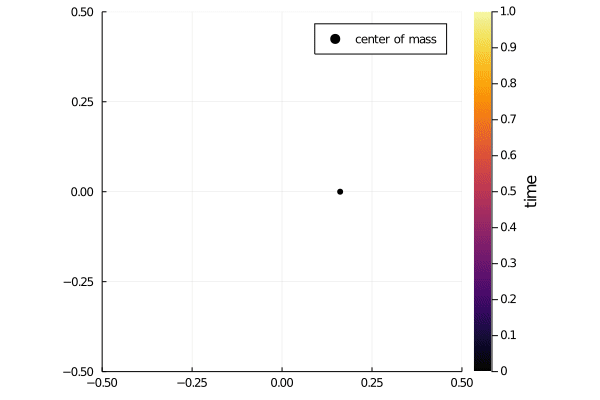

In [24]:
@gif for ti in 1:10:length(ts)
    print(ti, " ")
    plot()

    for i in 1:1 # Draw only the sun
        quiver!(x[i][1:40:ti],y[i][1:40:ti],quiver=(vx[i][1:40:ti]/100,vy[i][1:40:ti]/100),
            color=:grey, label=nothing)

        plot!(x[i][1:ti],y[i][1:ti],line_z=ts[1:ti],
            linewidth=4, label=nothing)
    end

    plot!(colorbar_title="time")
    
    all_current_coordinates = pps_solution(collect(ts)[ti])[2,:,:]
    center_of_mass = sum(all_current_coordinates .* masses, dims=1) ./ sum(masses)
    plot!([center_of_mass[1]], [center_of_mass[2]], line=nothing, marker=:circle, label="center of mass", color=:black)

    plot!(aspectratio=:equal, xlim=(-0.5,0.5), ylim=(-0.5,0.5))
end

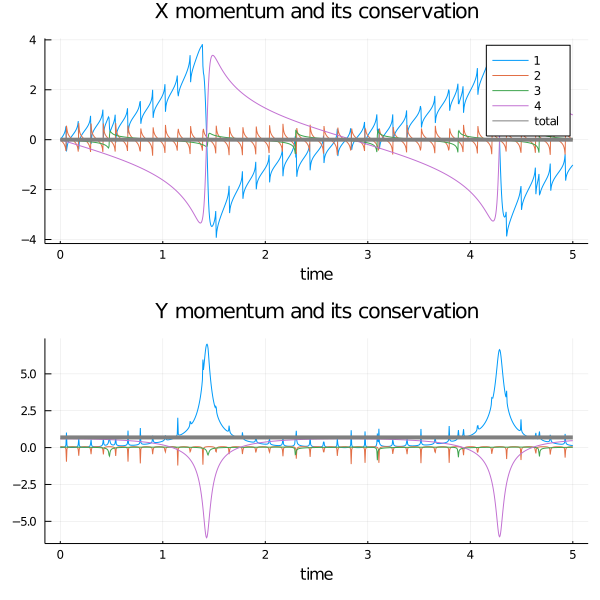

In [25]:
total_x_momentum = sum(vx .* masses)
total_y_momentum = sum(vy .* masses)


xplot = plot()
for i in 1:N
   plot!(ts, vx[i] .* masses[i], label=i)
end
plot!(ts, total_x_momentum, color=:grey, label="total", lw=4)
plot!(xlabel="time",title="X momentum and its conservation")

yplot = plot()
for i in 1:N
   plot!(ts, vy[i] .* masses[i], label=i)
end
plot!(ts, total_y_momentum, color=:grey, label="total", lw=4)
plot!(xlabel="time",title="Y momentum and its conservation", legend=false)

plot(xplot, yplot, layout=(2,1), size=(600,600))

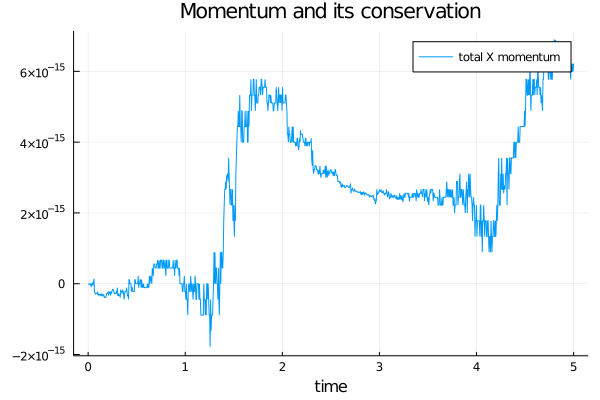

In [26]:
plot(ts, total_x_momentum, label="total X momentum")
plot!(xlabel="time",title="Momentum and its conservation")

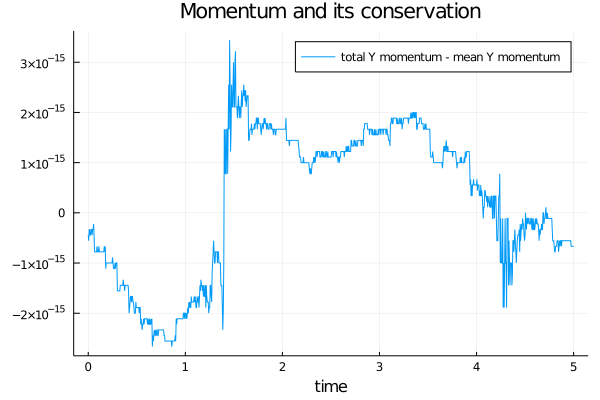

In [27]:
plot(ts, total_y_momentum .- sum(total_y_momentum)/length(total_y_momentum), label="total Y momentum - mean Y momentum")
plot!(xlabel="time",title="Momentum and its conservation")